In [1]:
import datastore
import pandas as pd

spot = datastore.getSpotPrice().dropna()

production = datastore.GetAllProductionMWh()
cons = datastore.getConsumptionGWh()
transCap = datastore.GetTransmissionCapTo()

temp = datastore.getDailyWeather()

In [34]:
non_matching_dates = production[~production.index.isin(spot.index)]

In [2]:
train_split = int(len(production) * 0.67)
# test_split = len(production) - train_split

dataset = pd.merge(production, cons, left_index=True, right_index=True)
dataset = pd.merge(dataset, transCap, left_index=True, right_index=True)
dataset = pd.merge(dataset, temp, left_index=True, right_index=True)
dataset = pd.merge(dataset, spot, left_index=True, right_index=True)

dataset = dataset.dropna()

In [5]:
from sklearn.preprocessing import MinMaxScaler

features = dataset.drop('spotPrice', axis=1)
target = dataset['spotPrice'].values.reshape(-1, 1)

featureScaler = MinMaxScaler()
targetScaler = MinMaxScaler()

x_train = featureScaler.fit_transform(features[:train_split])
x_test = featureScaler.fit_transform(features[train_split:])

y_train = targetScaler.fit_transform(target[:train_split])
y_test = targetScaler.fit_transform(target[train_split:])

In [6]:
import tensorflow as tf
import keras

train = keras.preprocessing.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=72, sampling_rate=1, batch_size=1
)

test = keras.preprocessing.timeseries_dataset_from_array(
    x_test, y_test, sequence_length=72, sampling_rate=1, batch_size=1
)

for batch in train.take(1):
    inputs, targets = batch

In [7]:
model = keras.Sequential()

model.add(keras.layers.LSTM(64, activation='relu', input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(keras.layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20480     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20545 (80.25 KB)
Trainable params: 20545 (80.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=10, patience=5)

log = model.fit(
    train, epochs=100, validation_data=test, callbacks=[callback]
)

Epoch 1/100

18356/18356 [==============================] - 101s 5ms/step - loss: 0.0085 - val_loss: 0.0201
Epoch 2/100
18356/18356 [==============================] - 98s 5ms/step - loss: 0.0080 - val_loss: 0.0219
Epoch 3/100
18356/18356 [==============================] - 101s 5ms/step - loss: 0.0081 - val_loss: 0.0209
Epoch 4/100
18356/18356 [==============================] - 101s 6ms/step - loss: 0.0080 - val_loss: 0.0204
Epoch 5/100
18356/18356 [==============================] - 101s 6ms/step - loss: 0.0079 - val_loss: 0.0207
Epoch 6/100
18356/18356 [==============================] - 100s 5ms/step - loss: 0.0082 - val_loss: 0.0208


8478/8478 [==============================] - 11s 1ms/step


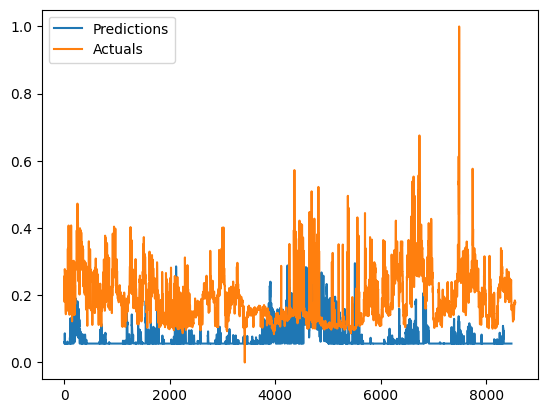

In [12]:
import matplotlib.pyplot as plt

predictions = targetScaler.inverse_transform(model.predict(test)
actuals = targetScaler.inverse_transform(y_test)

plt.plot(predictions, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.legend()
plt.show()


In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(actuals, predictions).numpy()